<a href="https://colab.research.google.com/github/anubhavanand1516/yamak.ai-NLP-/blob/main/anubhav_anand(Encoder_Decoder_model_with_an_Attention_Mechanism).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#title Check GPU
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  print('GPU device not found')
else:
  print('Found GPU at: {}'.format(device_name))

GPU device not found


In [ ]:
#title Version Info
print('tf version: ', tf.__version__)
print('tf.keras version:', tf.keras.__version__)


tf version:  2.8.0
tf.keras version: 2.8.0


In [ ]:
#title Time
!pip install ipython-autotime

%load_ext autotime

time: 196 µs (started: 2022-03-11 12:31:22 +00:00)


In [ ]:
#import all the  library
from random import randint#it give a random value
from numpy import array#it was used for creating N-dimension array
from numpy import argmax#it return the maxvalues in the array
import keras.backend as K
from tensorflow.keras import models
from numpy import array_equal
import numpy as np
from tensorflow.keras.models import Sequential, Model#sequential model is a linear model
from tensorflow.keras.layers import LSTM, Bidirectional#that used for store past information.
from tensorflow.keras.layers import Dense, Flatten #dense layer is used for matrix multiplication.
from tensorflow.keras import Input 
from tensorflow.keras.layers import TimeDistributed
from tensorflow.keras.layers import RepeatVector
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt #visualize the data in term of graph.
import matplotlib.ticker as ticker#it is used for creating GUI.

from tensorflow.keras.layers import Lambda
from tensorflow.keras import backend as K

tf.keras.backend.set_floatx('float64')

time: 18.3 ms (started: 2022-03-11 12:31:22 +00:00)


In [ ]:
# generate a sequence of random integers
def generate_sequence(length, n_unique):
	return [randint(1, n_unique-1) for _ in range(length)]

# one hot encode sequence
def one_hot_encode(sequence, n_unique):
	encoding = list()
	for value in sequence:
		vector = [0 for _ in range(n_unique)]
		vector[value] = 1
		encoding.append(vector)
	return array(encoding)

# decode a one hot encoded string
def one_hot_decode(encoded_seq):
	return [argmax(vector) for vector in encoded_seq]

# prepare data for the LSTM
def get_reversed_pairs(time_steps,vocabulary_size,verbose= False):
	# generate random sequence
	sequence_in = generate_sequence(time_steps, vocabulary_size)
	sequence_out = sequence_in[::-1]
	
	# one hot encode
	X = one_hot_encode(sequence_in, vocabulary_size)
	y = one_hot_encode(sequence_out, vocabulary_size)
	# reshape as 3D
	X = X.reshape((1, X.shape[0], X.shape[1]))
	y = y.reshape((1, y.shape[0], y.shape[1]))

	if(verbose):
		print('\nFor each input sequence (X), selecting ',time_steps,' random numbers beteen 1 and ',
		      vocabulary_size, ' (0 is reserved )')
	  
		print('\nA sample X ')
		print('X=%s' % (one_hot_decode(X[0])))
		print('\nreversed input sequence (X) is the output sequence (y) ')
		print('y=%s' % (one_hot_decode(y[0])))
	
		print('\nEach input and output sequences are converted one_hot_encoded format in ',
		      vocabulary_size,' dimensions')
		print('X=%s' % (X[0]))
		print('y=%s' % (y[0]))
	return X,y


def create_dataset(train_size, test_size, time_steps,vocabulary_size, verbose= False):
	pairs = [get_reversed_pairs(time_steps,vocabulary_size) for _ in range(train_size)]
	pairs=np.array(pairs).squeeze()
	X_train = pairs[:,0]
	y_train = pairs[:,1]
	pairs = [get_reversed_pairs(time_steps,vocabulary_size) for _ in range(test_size)]
	pairs=np.array(pairs).squeeze()
	X_test = pairs[:,0]
	y_test = pairs[:,1]	

	if(verbose):
		print('\nGenerated sequence datasets as follows (batch_size,time_steps, features)')
		print('X_train.shape: ', X_train.shape,'y_train.shape: ', y_train.shape)
		print('X_test.shape: ', X_test.shape,'y_test.shape: ', y_test.shape)
	
	return X_train, y_train, X_test, 	y_test

time: 62.1 ms (started: 2022-03-11 12:31:22 +00:00)


In [ ]:

def train_test(model, X_train, y_train , X_test, 	y_test, epochs=500, batch_size=32, patience=5,verbose=0):
	# patient early stopping
	es = EarlyStopping(monitor='val_accuracy', mode='max',  verbose=1, patience=patience)
	# train model
	print('training for ',epochs,' epochs begins with EarlyStopping(monitor= val_accuracy, patience=',patience,')....')
	history=model.fit(X_train, y_train, validation_split= 0.1, epochs=epochs,batch_size=batch_size, verbose=verbose, callbacks=[es])
	print(epochs,' epoch training finished...')

	# report training
	# list all data in history
	# evaluate the model
	_, train_acc = model.evaluate(X_train, y_train, batch_size=batch_size, verbose=0)
	_, test_acc = model.evaluate(X_test, 	y_test, batch_size=batch_size, verbose=0)
	print('\nPREDICTION ACCURACY (%):')
	print('Train: %.3f, Test: %.3f' % (train_acc*100, test_acc*100))
	# summarize history for accuracy
	plt.plot(history.history['accuracy'])
	plt.plot(history.history['val_accuracy'])
	plt.title(model.name+' accuracy')
	plt.ylabel('accuracy')
	plt.xlabel('epoch')
	plt.legend(['train', 'val'], loc='upper left')
	plt.show()
	# summarize history for loss
	plt.plot(history.history['loss'])
	plt.plot(history.history['val_loss'])
	plt.title(model.name+' loss')
	plt.ylabel('loss')
	plt.xlabel('epoch')
	plt.legend(['train', 'val'], loc='upper left')
	plt.show()




  
	# spot check some examples
	space = 3*len(one_hot_decode(y_test[0]))
	print('10 examples from test data...')
	print('Input',' '*(space-4) ,'Expected',' '*(space-7) ,
	      'Predicted',' '*(space-5) ,'T/F')
	correct =0 
	sampleNo =  10

	predicted= model.predict(X_test[:sampleNo], batch_size=batch_size)
	for sample in range(0,sampleNo):
		if (one_hot_decode(y_test[sample])== one_hot_decode(predicted[sample])):
			correct+=1
		print( one_hot_decode(X_test[sample]), ' ', 
					one_hot_decode(y_test[sample]),' ', one_hot_decode(predicted[sample]),
					' ',one_hot_decode(y_test[sample])== one_hot_decode(predicted[sample]))
	print('Accuracy: ', correct/sampleNo)
	

time: 55 ms (started: 2022-03-11 12:31:22 +00:00)


In [ ]:
n_timesteps_in = 4

n_features = 10  
# generate random sequence
X,y = get_reversed_pairs(n_timesteps_in,  n_features, verbose=True)
# generate datasets
train_size= 2000 
test_size = 200 

X_train, y_train , X_test, 	y_test=create_dataset(train_size, test_size, n_timesteps_in,n_features , verbose=True)


For each input sequence (X), selecting  4  random numbers beteen 1 and  10  (0 is reserved )

A sample X 
X=[3, 1, 3, 4]

reversed input sequence (X) is the output sequence (y) 
y=[4, 3, 1, 3]

Each input and output sequences are converted one_hot_encoded format in  10  dimensions
X=[[0 0 0 1 0 0 0 0 0 0]
 [0 1 0 0 0 0 0 0 0 0]
 [0 0 0 1 0 0 0 0 0 0]
 [0 0 0 0 1 0 0 0 0 0]]
y=[[0 0 0 0 1 0 0 0 0 0]
 [0 0 0 1 0 0 0 0 0 0]
 [0 1 0 0 0 0 0 0 0 0]
 [0 0 0 1 0 0 0 0 0 0]]

Generated sequence datasets as follows (batch_size,time_steps, features)
X_train.shape:  (2000, 4, 10) y_train.shape:  (2000, 4, 10)
X_test.shape:  (200, 4, 10) y_test.shape:  (200, 4, 10)
time: 100 ms (started: 2022-03-11 12:31:22 +00:00)


In [ ]:
latentSpaceDimension = 16 

time: 1.86 ms (started: 2022-03-11 12:31:22 +00:00)


In [ ]:
def create_hard_coded_decoder_input_model(batch_size):
  # The first part is encoder
  encoder_inputs = Input(shape=(n_timesteps_in, n_features), name='encoder_inputs')
  encoder_lstm = LSTM(latentSpaceDimension, return_state=True,  name='encoder_lstm')
  encoder_outputs, state_h, state_c = encoder_lstm(encoder_inputs)
  
  # initial context vector is the states of the encoder
  states = [state_h, state_c]
  
  # Set up the decoder layers
  decoder_inputs = Input(shape=(1, n_features))
  decoder_lstm = LSTM(latentSpaceDimension, return_sequences=True, 
                      return_state=True, name='decoder_lstm')
  decoder_dense = Dense(n_features, activation='softmax',  name='decoder_dense')

  all_outputs = []
  decoder_input_data = np.zeros((batch_size, 1, n_features))
  decoder_input_data[:, 0, 0] = 1 #
  
  # that is, [1 0 0 0 0 0 0 0 0 0] is the initial input for each loop
  inputs = decoder_input_data
  # decoder will only process one timestep at a time.
  for _ in range(n_timesteps_in):
      # Run the decoder on one timestep
      outputs, state_h, state_c = decoder_lstm(inputs,
                                              initial_state=states)
      outputs = decoder_dense(outputs)
      # Store the current prediction (we will concatenate all predictions later)
      all_outputs.append(outputs)
      # Reinject the outputs as inputs for the next loop iteration
      # as well as update the states
      inputs = outputs
      states = [state_h, state_c]

  #-- Concatenate all predictions such as [batch_size, timesteps, features]
  decoder_outputs = Lambda(lambda x: K.concatenate(x, axis=1))(all_outputs)

  #-- Define and compile model 
  model = Model(encoder_inputs, decoder_outputs, name='model_encoder_decoder')
  model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])
  return model

time: 79.2 ms (started: 2022-03-11 12:51:51 +00:00)


In [ ]:
batch_size = 10
model_encoder_decoder=create_hard_coded_decoder_input_model(batch_size=batch_size)
model_encoder_decoder.summary()

Model: "model_encoder_decoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 encoder_inputs (InputLayer)    [(None, 4, 10)]      0           []                               
                                                                                                  
 encoder_lstm (LSTM)            [(None, 16),         1728        ['encoder_inputs[0][0]']         
                                 (None, 16),                                                      
                                 (None, 16)]                                                      
                                                                                                  
 decoder_lstm (LSTM)            [(10, 1, 16),        1728        ['encoder_lstm[0][1]',           
                                 (None, 16),                      'encoder_lst

training for  50  epochs begins with EarlyStopping(monitor= val_accuracy, patience= 5 )....
Epoch 1/50
180/180 [==============================] - 11s 18ms/step - loss: 2.1530 - accuracy: 0.2533 - val_loss: 1.9316 - val_accuracy: 0.3175
Epoch 2/50
180/180 [==============================] - 1s 7ms/step - loss: 1.7726 - accuracy: 0.3465 - val_loss: 1.6543 - val_accuracy: 0.3675
Epoch 3/50
180/180 [==============================] - 1s 7ms/step - loss: 1.6010 - accuracy: 0.3806 - val_loss: 1.5294 - val_accuracy: 0.3875
Epoch 4/50
180/180 [==============================] - 1s 7ms/step - loss: 1.5060 - accuracy: 0.3911 - val_loss: 1.4537 - val_accuracy: 0.4012
Epoch 5/50
180/180 [==============================] - 1s 7ms/step - loss: 1.4401 - accuracy: 0.4017 - val_loss: 1.3951 - val_accuracy: 0.4213
Epoch 6/50
180/180 [==============================] - 1s 7ms/step - loss: 1.3826 - accuracy: 0.4131 - val_loss: 1.3406 - val_accuracy: 0.4325
Epoch 7/50
180/180 [==============================] - 

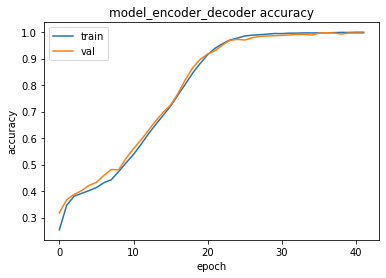

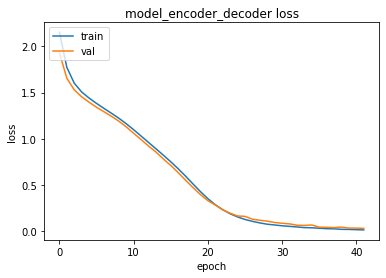

10 examples from test data...
Input          Expected       Predicted         T/F
[5, 3, 2, 2]   [2, 2, 3, 5]   [2, 2, 3, 5]   True
[7, 9, 3, 7]   [7, 3, 9, 7]   [7, 3, 9, 7]   True
[6, 7, 1, 5]   [5, 1, 7, 6]   [5, 1, 7, 6]   True
[2, 8, 9, 4]   [4, 9, 8, 2]   [4, 9, 8, 2]   True
[2, 5, 3, 2]   [2, 3, 5, 2]   [2, 3, 5, 2]   True
[6, 5, 4, 2]   [2, 4, 5, 6]   [2, 4, 5, 6]   True
[7, 7, 7, 6]   [6, 7, 7, 7]   [6, 7, 7, 7]   True
[8, 8, 9, 2]   [2, 9, 8, 8]   [2, 9, 8, 8]   True
[7, 6, 9, 9]   [9, 9, 6, 7]   [9, 9, 6, 7]   True
[7, 6, 3, 1]   [1, 3, 6, 7]   [1, 3, 6, 7]   True
Accuracy:  1.0
time: 1min 32s (started: 2022-03-11 12:53:15 +00:00)


In [ ]:
train_test(model_encoder_decoder, X_train, y_train , X_test, 	y_test, batch_size=batch_size,epochs=50,patience=5 ,verbose=1)